In [16]:
import os
import cv2
import joblib
import numpy as np
from PIL import Image, ImageFilter, ImageOps
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Dropout, Conv2DTranspose, ZeroPadding2D
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Activation, Add, AveragePooling2D, Lambda, SeparableConv2D, GlobalAveragePooling2D, DepthwiseConv2D, LeakyReLU, add

In [17]:
def resize_with_padding(image, target_size=(128, 128)):
    image = ImageOps.contain(image, target_size, method=Image.Resampling.LANCZOS)
    padded_img = ImageOps.pad(image, target_size, method=Image.Resampling.LANCZOS, color=(255))
    return padded_img

def load_images_with_padding(folder, target_size=(128, 128)):
    images = []
    for filename in os.listdir(folder):
        if 'png' in filename or 'PNG' in filename or 'jpg' in filename or 'jpeg' in filename:
            image = Image.open(os.path.join(folder, filename)).convert('L')
            padded_img = resize_with_padding(image, target_size)
            images.append(img_to_array(padded_img) / 255.0)
    return np.array(images)

In [18]:
# MÉTRICAS DE AVALIAÇÃO
def SSIM(y_true, y_pred):
    # between 0 and 1. Higher the better
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

def PSNR(y_true, y_pred):
    # should be between 30 and 50. Higher the better
    return tf.image.psnr(y_true, y_pred, max_val=1.0)


In [19]:
reference_images = load_images_with_padding(r'../dados/clean')
noisy_images = load_images_with_padding(r'../dados/noisy')

In [20]:
x_train, x_val, y_train, y_val = train_test_split(noisy_images, reference_images, test_size=0.2, random_state=42)

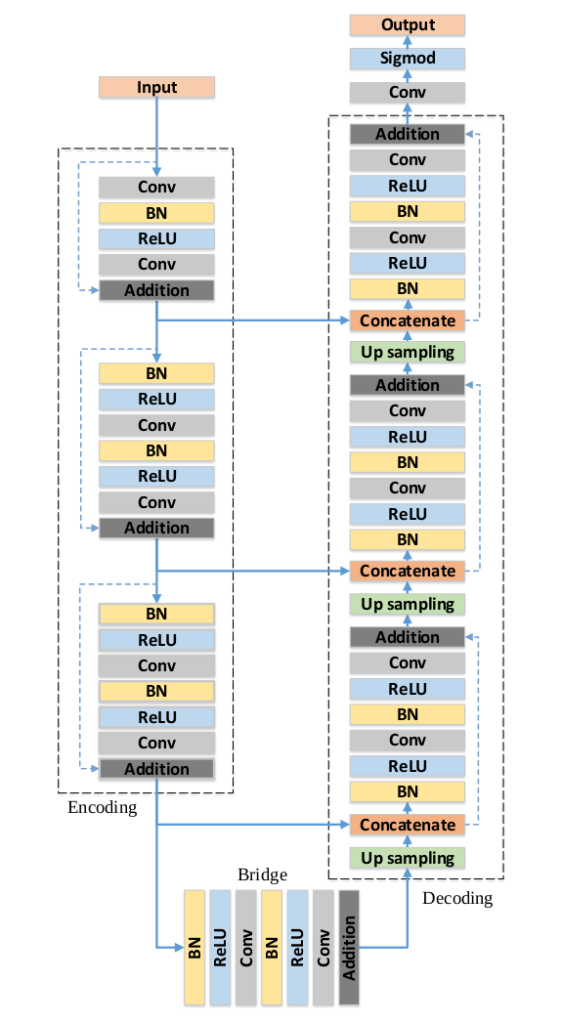

In [21]:
def conv_block(input_tensor, filters, strides, d_rates):
    x = Conv2D(filters[0], kernel_size=1, kernel_initializer='he_uniform', dilation_rate=d_rates[0])(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters[1], kernel_size=3, strides=strides, kernel_initializer='he_uniform', padding='same', dilation_rate=d_rates[1])(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters[2], kernel_size=1, kernel_initializer='he_uniform', dilation_rate=d_rates[2])(x)
    x = BatchNormalization()(x)

    shortcut = Conv2D(filters[2], kernel_size=1, kernel_initializer='he_uniform', strides=strides)(input_tensor)
    shortcut = BatchNormalization()(shortcut)

    x = add([x, shortcut])
    x = Activation('relu')(x)

    return x


def identity_block(input_tensor, filters, d_rates):
    x = Conv2D(filters[0], kernel_size=1, kernel_initializer='he_uniform', dilation_rate=d_rates[0])(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters[1], kernel_size=3, kernel_initializer='he_uniform', padding='same', dilation_rate=d_rates[1])(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters[2], kernel_size=1, kernel_initializer='he_uniform', dilation_rate=d_rates[2])(x)
    x = BatchNormalization()(x)

    x = add([x, input_tensor])
    x = Activation('relu')(x)

    return x

def one_side_pad(x):
    x = ZeroPadding2D((1, 1))(x)
    x = Lambda(lambda x: x[:, :-1, :-1, :])(x)
    return x

In [22]:
shape = x_train.shape[1:]
droprate = 0.30
inputs = Input(shape)
conv_1 = Conv2D(32, (3, 3), strides=(1, 1), kernel_initializer='he_uniform', padding='same')(inputs)
conv_1 = BatchNormalization()(conv_1)
conv_1 = Activation("relu")(conv_1)
f1 = conv_1

conv_2 = Conv2D(64, (3, 3), strides=(2, 2), kernel_initializer='he_uniform', padding='same')(conv_1)
conv_2 = BatchNormalization()(conv_2)
conv_2 = Activation("relu")(conv_2)

conv_3 = Conv2D(64, (3, 3), strides=(1, 1), kernel_initializer='he_uniform', padding='same')(conv_2)
conv_3 = BatchNormalization()(conv_3)
conv_3 = Activation("relu")(conv_3)

f2 = conv_3


pool_1 = MaxPooling2D((2, 2), strides=(2, 2))(conv_3)

conv_block1 = conv_block(pool_1, filters=[64, 64, 256], strides=(1, 1), d_rates=[1, 1, 1])
identity_block1 = identity_block(conv_block1, filters=[64, 64, 256], d_rates=[1, 1, 1])
identity_block2 = identity_block(identity_block1, filters=[64, 64, 256], d_rates=[1, 1, 1])
f3 = identity_block2

conv_block2 = conv_block(identity_block2, filters=[128, 128, 256], strides=(2, 2), d_rates=[1, 1, 1])
identity_block3 = identity_block(conv_block2, filters=[128, 128, 256], d_rates=[1, 1, 1])
identity_block4 = identity_block(identity_block3, filters=[128, 128, 256], d_rates=[1, 1, 1])
identity_block5 = identity_block(identity_block4, filters=[128, 128, 256], d_rates=[1, 1, 1])
f4 = identity_block5

identity_block10 = conv_block(identity_block5, filters=[256, 256, 512], strides=(2, 2), d_rates=[1, 1, 1])
for i in range(5):
  identity_block10 = identity_block(identity_block10, filters=[256, 256, 512], d_rates=[1, 2, 1])

f5 = identity_block10

conv_block4 = conv_block(identity_block10, filters=[512, 512, 1024], strides=(2, 2), d_rates=[1, 1, 1])
identity_block11 = identity_block(conv_block4, filters=[512, 512, 1024], d_rates=[1, 2, 1])
identity_block12 = identity_block(identity_block11, filters=[512, 512, 1024], d_rates=[1, 2, 1])
f6 = identity_block12

o = f6

o = (BatchNormalization())(o)
o = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(o)
o = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(o)
o = Dropout(droprate)(o)

o = Conv2DTranspose(1024, (2, 2), strides=(2, 2), padding='same')(o)
o = (concatenate([o, f5]))
o = (BatchNormalization())(o)
o = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(o)
o = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(o)
o = Dropout(droprate)(o)


#o = (UpSampling2D((2, 2)))(o)
o = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(o)
o = (concatenate([o, f4]))
o = (BatchNormalization())(o)
o = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(o)
o = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(o)
o = Dropout(droprate)(o)


#o = (UpSampling2D((2, 2)))(o)
o = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(o)
o = (concatenate([o, f3]))
o = (BatchNormalization())(o)
o = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(o)
o = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(o)
o = Dropout(droprate)(o)


#o = (UpSampling2D((2, 2)))(o)
o = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(o)
o = (concatenate([o, f2]))
o = (BatchNormalization())(o)
o = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(o)
o = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(o)
o = Dropout(droprate)(o)

#o = (UpSampling2D((2, 2)))(o)
o = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(o)
o = (concatenate([o, f1]))
o = (BatchNormalization())(o)
o = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(o)
o = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(o)


o = Conv2D(1, (3, 3), padding='same', activation='sigmoid')(o)

model = Model(inputs=inputs, outputs=o)

model.compile(optimizer=Adam(), loss = 'binary_crossentropy', metrics = [PSNR, tf.keras.metrics.RootMeanSquaredError(name='rmse'),
                                                                        SSIM])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 128, 128, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 128, 128, 32)      │             320 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_7         │ (None, 128, 128, 32)      │             128 │ conv2d_7[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_5 (Activation)     │ (None, 128, 128, 32)      │               0 │ batch_normalization_7[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_8 (Conv2D)             │ (None, 64, 64, 64)        │          18,496 │ activation_5[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_8         │ (None, 64, 64, 64)        │             256 │ conv2d_8[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_6 (Activation)     │ (None, 64, 64, 64)        │               0 │ batch_normalization_8[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_9 (Conv2D)             │ (None, 64, 64, 64)        │          36,928 │ activation_6[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_9         │ (None, 64, 64, 64)        │             256 │ conv2d_9[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_7 (Activation)     │ (None, 64, 64, 64)        │               0 │ batch_normalization_9[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 32, 32, 64)        │               0 │ activation_7[0][0]         │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_10 (Conv2D)            │ (None, 32, 32, 64)        │           4,160 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_10        │ (None, 32, 32, 64)        │             256 │ conv2d_10[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_8 (Activation)     │ (None, 32, 32, 64)        │               0 │ batch_normalization_10[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_11 (Conv2D)            │ (None, 32, 32, 64)        │          36,92

 Total params: 54,052,353 (206.19 MB)

 Trainable params: 54,008,897 (206.03 MB)

 Non-trainable params: 43,456 (169.75 KB)

In [24]:
early_stopping = EarlyStopping(
    monitor='val_ssim',
    patience=10,
    verbose=0,
    mode='max',
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)

checkpoint = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_ssim',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [25]:
history = model.fit(x_train,
                    y_train,
                    epochs=40,
                    batch_size=16,
                    shuffle=True,
                    validation_data=(x_val, y_val),
                    callbacks=[checkpoint, early_stopping])

Epoch 1/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.2100 - psnr: 22.7565 - rmse: 0.0878 - ssim: 0.5786
Epoch 1: val_ssim improved from -inf to 0.80388, saving model to best_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 243s 3s/step - loss: 0.2098 - psnr: 22.7735 - rmse: 0.0875 - ssim: 0.5798 - val_loss: 41.7213 - val_psnr: 21.9436 - val_rmse: 0.0828 - val_ssim: 0.8039
Epoch 2/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.1909 - psnr: 24.5689 - rmse: 0.0621 - ssim: 0.7273
Epoch 2: val_ssim did not improve from 0.80388
66/66 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - loss: 0.1909 - psnr: 24.5698 - rmse: 0.0621 - ssim: 0.7274 - val_loss: 0.2215 - val_psnr: 20.3762 - val_rmse: 0.0972 - val_ssim: 0.6354
Epoch 3/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.1881 - psnr: 24.6629 - rmse: 0.0614 - ssim: 0.7494
Epoch 3: val_ssim did not improve from 0.80388
66/66 ━━━━━━━━━━━━━━━━━━━━ 223s 3s/step - loss: 0.1881 - psnr: 24.6652 - rmse: 0.0614 - ssim: 0.7495 - val_loss: 0.1986 - val_psnr: 22.5184 - val_rmse: 0.0763 - val_ssim: 0.6888
Epoch 4/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.1849 - psnr: 24.8974 - rmse: 0.0602 - ssim: 0.7675
Epoch 4: val_ssim did not improve from 0.